In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import joblib

from lab2 import Helper

In [2]:
df1 = pd.read_csv('Data/df1.csv')
df2 = pd.read_csv('Data/df2.csv')

display(df1.head(3), df2.head(3))

,id,age,cholesterol,gluc,smoke,alco,active,cardio,gender_2,bmi-feature_obese (class I),bmi-feature_obese (class II),bmi-feature_obese (class III),bmi-feature_overweight,bp-feature_healthy,bp-feature_hypertension crises,bp-feature_stage 1 hypertension,bp-feature_stage 2 hypertension
0,0,18393,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0
1,1,20228,3,1,0,0,1,1,0,1,0,0,0,0,0,0,1
2,2,18857,3,1,0,0,0,1,0,0,0,0,0,0,0,1,0


,id,age,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,gender_2
0,0,18393,21,110,80,1,1,0,0,1,0,1
1,1,20228,34,140,90,3,1,0,0,1,1,0
2,2,18857,23,130,70,3,1,0,0,0,1,0


In [3]:
# Drop id as its not useful
df1, df2 = df1.drop('id', axis=1), df2.drop('id', axis=1)

### 2.4 - Välja modell

Chosen models:
* Logistic regression
* decision tree
* random forest

The reason for choosing the above models is quite simple. The problem where trying to solve is that of classification. That immediately limited the options for which models we could use. We can for example not use (multiple) linear regression, given that such a model wouldn't be able to do classification (e.g give 1's & 0's for if the patient has cardiovascular disease or not).

As for why i decided to use logistic regression, decision tree.. etc. over something like SVM or KNN all comes down to the datasets. The data simply looked to be more suited towards something like a decision tree given how categorical it was. Now where obviously using two datasets that are quite different, but i still figured that an algorithm like logistic regression was up for the task. Especially given that it uses a continuous S-curve for classifying.

In [4]:
df1_x, df1_y = df1.drop('cardio', axis=1), df1['cardio']
df2_x, df2_y = df2.drop('cardio', axis=1), df2['cardio']

display(
    df1_x.head(1),
    df2_x.head(1)
)

,age,cholesterol,gluc,smoke,alco,active,gender_2,bmi-feature_obese (class I),bmi-feature_obese (class II),bmi-feature_obese (class III),bmi-feature_overweight,bp-feature_healthy,bp-feature_hypertension crises,bp-feature_stage 1 hypertension,bp-feature_stage 2 hypertension
0,18393,1,1,0,0,1,1,0,0,0,0,0,0,1,0


,age,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,gender_2
0,18393,21,110,80,1,1,0,0,1,1


In [5]:
# split data into a train val test split.

df1_x_train, df1_x_val, df1_x_test, df1_y_train, df1_y_val, df1_y_test = Helper.train_val_test_split(df1_x, df1_y, split_size=0.2, rand_state=42)
df2_x_train, df2_x_val, df2_x_test, df2_y_train, df2_y_val, df2_y_test = Helper.train_val_test_split(df2_x, df2_y, split_size=0.2, rand_state=42)

display(
    (df1_x_train.shape, df1_y_train.shape, df1_x_val.shape, df1_y_val.shape, df1_x_test.shape, df1_y_test.shape),
    (df2_x_train.shape, df2_y_train.shape, df2_x_val.shape, df2_y_val.shape, df2_x_test.shape, df2_y_test.shape),
)

((40918, 15), (40918,), (13640, 15), (13640,), (13640, 15), (13640,))

((40918, 10), (40918,), (13640, 10), (13640,), (13640, 10), (13640,))

##### Before we continue, i'd like to go over why we even scale the data and do hyperparameter tuning in the first place. There are several reasons for why you'd like to scale the data. In the case of normalization, we'd like to make sure that the weight/importance thats put on various metrics is proprtionally correct. We do this by transforming the data to only contain values between 0 and 1. Standardization on the other hand is useful when the data you've got is known to follow a standard distrubution. Standardization thus involves transforming the data into a standard normal distribution.<br><br>Hyperparameter tuning is a different beast all togeather. Here we tune the various parameters that a model has to offer. Things like the maximum number of interations before the model converges, or the maximum depth of a tree given by the decision tree classifier.<br> Now than, lets continue.

### All parameters and corresponding explanations as to why i made the choices i made.
###### NOTE: Obvious choices lack a reason



#### Grid Search parameters
- Scoring: 'Accuracy'
    - Reason: Given that where using classification based models, accuracy seems like the only appropriate metric, given it directly tells us how good the model's doing at actually classifying things correctly.
- cv: 5
    - Reason: After some online research, it seems as though 5 is a generally good number of folds for avoiding things like overfitting.

#### LogisticRegression
- Chosen parameters
    - penalty: 'elasticnet'
        - Reason: We'd like to use both L1 and or L2 regularization in the grid search.
    
    - solver: saga

    - max_iter: 1000
        - Reason: Some models require quite a few iterations before they converge. Given that max_iter only specifies the maximum number of allowed iterations before "giving up" on a model converging, we won't actually be wasting any compute power on running a more iterations than will be needed.

- Hyperparameters

    - l1_ratio: [0.0, 0.05, ... 1.0]
        - Reason: Uses both solvers independently as well as in ratios with an increment resolution of 5%. This simply just seems like a resonable thing to do.
    
#### DecisionTreeClassifier
- Chosen parameters
    - max_depth: None (Default)
        - Reason: Not needed as we'd like expand the nodes until all leaves are pure.

    - min_samples_split: 2 (Default)
        - Reason: We'd like to only split if we've got 2 samples or more 

    - min_samples_leaf: 1 (Default)
        - Reason: We'd like our leaf nodes to only contain one sample

    - min_weight_fraction_leaf: 0 (Default)
        - Reason: We'd like to keep building the tree regardless of "amount of data" (so to say) available.

    - max_leaf_nodes: None (Default)
        - Reason: Generally not needed, as we'd simply like to build the tree until we've got pure leaves, not obsess about impurity decrease.

    - min_impurity_decrease: 0 (Default)
        - Reason: We'd like to keep splitting even if the impurity decrease is low. I dont think this will result in overfitting.

    - class_weight: None (Default)
        - Reason: We've got no clue about the importance of our classes.

    - ccp_alpha: 0 (Default)
        - Reason: Don't think we need this, as it won't meaningfully decrease the complexity of the tree.

- Hyperparameters
    - criterion ['gini', 'entropy', 'log_loss']
    - splitter ['best', 'random']
    - max_features: [None, 'sqrt', 'log2']


#### RandomForestClassifier
###### Note: Matching 'Chosen parameters' from above have been omitted, given the models both rely on decision trees. This is purely for aesthetics.
- Chosen parameters

    - bootstrap: True (Default)
        - Reason: Part of what sets random forest and decision tree apart. So it'd be dumb to not use it.
        
    - oob_score: False (Default)
        - Reason: Part of what sets random forest and decision tree apart. So it'd be dumb to not use it.

- Hyperparameters
    - n_estimators: [10, 20, ... 100]
        - Reason: Seemed like a resonable range. Random forest doesn't "slow down" unlike some other algorithms, and eventually stabalizes, meaning you you won't gain anything by adding more trees. Our dataset also isnt particularly large or complex.
    
    - criterion ['gini', 'entropy', 'log_loss']
    - max_features: [None, 'sqrt', 'log2']
    
    - max_samples: [None, 0.1, 0.2, ... 1.0] # would this actually work?
        - Reason: We'll try all ratios, see what works best. Simple as that.

In [6]:
# All the data needed for choosing the right model and doing hyperparameter tuning via GridSearchCV

datasets = {
    'df1': {
        'x_train': df1_x_train,
        'x_val': df1_x_val,
        'x_test': df1_x_test,
        'y_train': df1_y_train,
        'y_val': df1_y_val,
        'y_test': df1_y_test
    },
    
    'df2': {
        'x_train': df2_x_train,
        'x_val': df2_x_val,
        'x_test': df2_x_test,
        'y_train': df2_y_train,
        'y_val': df2_y_val,
        'y_val': df2_y_test
     }
}


model_data = {
    'logistic_regression': {
        'model': LogisticRegression(),
        'search space': {
            # Chosen parameters (defaults excluded)
            'penalty': ['elasticnet'],
            'solver': ['saga'],
            'max_iter': [1000],
            
            # Hyperparamaters
            'l1_ratio' : [round(x / 20, 2) for x in range(21)]
        }
    },
    
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'search space': {
            
            # Hyperparamaters
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random'],
            'max_features' : [None, 'sqrt', 'log2'],
        }
    },
    
    'random_forest': {
        'model': RandomForestClassifier(),
        'search space': {
            
            # Hyperparamaters
            'n_estimators': [x for x in range(10, 110, 10)],
            
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_features' : [None, 'sqrt', 'log2']
        }
    },
}

In [7]:
model_metrics = pd.DataFrame(columns=['Dataset', 'Scaling', 'Model', 'Hyper params', 'Accuracy'])
model_metrics

,Dataset,Scaling,Model,Hyper params,Accuracy


##### The below code roughly follows this control flow.

<img src="hell.png" alt="Alternative text"/>

In [8]:
models = [] 

# Loop through all datasets
for dataset_name, dataset in datasets.items():
    
    # Loop through and use the minmax and standard scaler
    for scaler_name in ['minmax', 'standard']:
        
        scaled_x_train, scaled_x_val = Helper.scaler(scaler_name, dataset['x_train'], dataset['x_val'])

        # loop through all models
        for model_name, data in model_data.items():
            
            # Search and find the best hyperparamters
            GS = GridSearchCV(
                estimator = data['model'],
                param_grid = data['search space'],
                scoring = 'accuracy',
                n_jobs=2,
                cv = 5,
            )
            
            # Both fits the model within the GS objet and appends it to the list
            models.append(GS.fit(scaled_x_train, dataset['y_train']))
            
            val_pred = GS.predict(scaled_x_val)

            score = accuracy_score(y_true=dataset['y_val'], y_pred=val_pred)
            
            # Add data to dataframe
            model_metrics.loc[len(model_metrics.index)] = [
                dataset_name,
                scaler_name,
                model_name,
                GS.best_params_,
                score
            ]

##### Based on the results, it appears that the [INSERT] model ran on the [INSERT] dataset gave the best accuracy. 

In [9]:
display(model_metrics.sort_values(by=['Accuracy'], ascending=False))

,Dataset,Scaling,Model,Hyper params,Accuracy
3,df1,standard,logistic_regression,"{'l1_ratio': 0.15, 'max_iter': 1000, 'penalty'...",0.705132
0,df1,minmax,logistic_regression,"{'l1_ratio': 0.95, 'max_iter': 1000, 'penalty'...",0.705059
2,df1,minmax,random_forest,"{'criterion': 'entropy', 'max_features': None,...",0.642962
5,df1,standard,random_forest,"{'criterion': 'entropy', 'max_features': None,...",0.640323
4,df1,standard,decision_tree,"{'criterion': 'log_loss', 'max_features': 'log...",0.612463
1,df1,minmax,decision_tree,"{'criterion': 'gini', 'max_features': 'log2', ...",0.611437
6,df2,minmax,logistic_regression,"{'l1_ratio': 1.0, 'max_iter': 1000, 'penalty':...",0.503519
9,df2,standard,logistic_regression,"{'l1_ratio': 0.3, 'max_iter': 1000, 'penalty':...",0.503372
8,df2,minmax,random_forest,"{'criterion': 'entropy', 'max_features': None,...",0.496481
7,df2,minmax,decision_tree,"{'criterion': 'entropy', 'max_features': 'log2...",0.495968


In [104]:
# Get the most highest accuracy for each model class
top_models = model_metrics.groupby('Model')['Accuracy'].max()

# Find the rows within the dataframe
top_models = model_metrics.loc[model_metrics['Accuracy'].isin(top_models)]

# Get the model objects for each respective model class
best_models = [models[i] for i in top_models.index]

# Set column text width to make the hyper parameters display correctly
pd.options.display.max_colwidth = 100

display(top_models.sort_values(by=['Accuracy'], ascending=False))

# Revert back to default
pd.options.display.max_colwidth = 50

,Dataset,Scaling,Model,Hyper params,Accuracy
3,df1,standard,logistic_regression,"{'l1_ratio': 0.15, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}",0.705132
2,df1,minmax,random_forest,"{'criterion': 'entropy', 'max_features': None, 'n_estimators': 80}",0.642962
4,df1,standard,decision_tree,"{'criterion': 'log_loss', 'max_features': 'log2', 'splitter': 'random'}",0.612463


### 2.5 Ensemble

In [11]:
# Scale with minmax because thats what the majority of the models work best on.
# NOTE: even if this potentially leads to some accuracy loss, the actual effect is negligable.
scaled_x_train, scaled_x_val = Helper.scaler('standard', df1_x_train, df1_x_val)

vote_clf = VotingClassifier([
    (top_models['Model'].iloc[0], best_models[0]),
    (top_models['Model'].iloc[1], best_models[1]),
    (top_models['Model'].iloc[2], best_models[2]),
], voting = "hard")

vote_clf.fit(scaled_x_train, df1_y_train)
vote_clf_pred = vote_clf.predict(scaled_x_val)

### 2.6 Evalueringar

random_forest:
              precision    recall  f1-score   support

           0       0.64      0.74      0.69      6870
           1       0.69      0.58      0.63      6770

    accuracy                           0.66     13640
   macro avg       0.66      0.66      0.66     13640
weighted avg       0.66      0.66      0.66     13640

logistic_regression:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      6870
           1       0.73      0.64      0.68      6770

    accuracy                           0.71     13640
   macro avg       0.71      0.70      0.70     13640
weighted avg       0.71      0.71      0.70     13640

decision_tree:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62      6870
           1       0.61      0.60      0.61      6770

    accuracy                           0.61     13640
   macro avg       0.61      0.61      0.61     13640
weighted avg       0.61

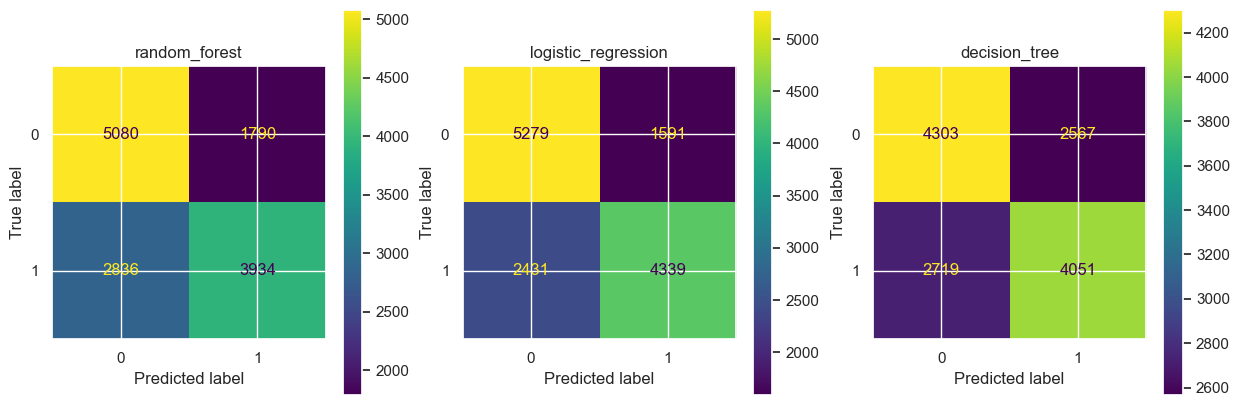

In [109]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Loop over the best models for each category
for index, model in enumerate(best_models): 
    # Get model name from dataframe
    model_name = top_models['Model'].iloc[index]
    
    pred = model.predict(scaled_x_val)
    
    # Generate confusion matrix
    cm = confusion_matrix(df1_y_val, pred)
    ConfusionMatrixDisplay(cm).plot(ax=axs[index])    
    axs[index].set_title(model_name)

    print(f"{model_name}:\n{classification_report(df1_y_val, pred)}")

              precision    recall  f1-score   support

           0       0.66      0.67      0.66      6870
           1       0.66      0.64      0.65      6770

    accuracy                           0.66     13640
   macro avg       0.66      0.66      0.66     13640
weighted avg       0.66      0.66      0.66     13640



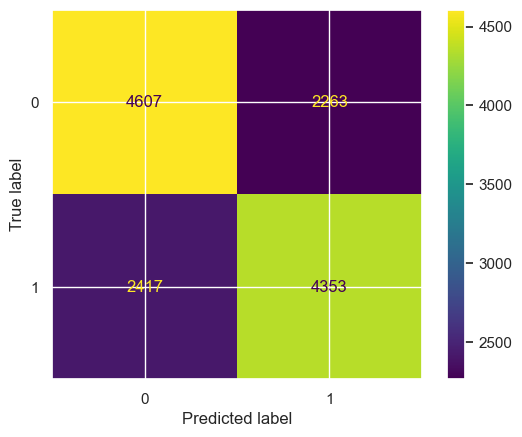

In [110]:
print(f"{classification_report(df1_y_val, vote_clf_pred)}")

cm = confusion_matrix(df1_y_val, vote_clf_pred)
ConfusionMatrixDisplay(cm).plot();

### 2.7 "Deploy" - spara modell

In [141]:
# Pull 100 random samples from df1
test = df1.sample(100, replace=False)

# Drop them from df1 to make sure they're unique
train = df1.drop(test.index)

# drop the answere
test = test.drop('cardio', axis=1)

test.to_csv(path_or_buf='Data/test_samples.csv', index=False)

In [121]:
x_train, y_train = train.drop('cardio', axis=1), train['cardio']
x_train.shape, y_train.shape

((68098, 15), (68098,))

In [142]:
# drop cardio from train and export it. We dont need train anymore as we've split it.
train = train.drop('cardio', axis=1)
train.to_csv(path_or_buf='Data/for_scaling.csv', index=False)

In [155]:
# Scale data for training
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(x_train)

best_model = best_models[1]
best_model.fit(scaled_x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=2,
             param_grid={'l1_ratio': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,
                                      0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
                                      0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
                         'max_iter': [1000], 'penalty': ['elasticnet'],
                         'solver': ['saga']},
             scoring='accuracy')

In [137]:
# Save model
joblib.dump(best_model, 'Data/best_model.pkl');